In [54]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import tensorflow.keras.utils 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

In [10]:
# read in CSV files, add column labels 

df_original = pd.read_csv('enviro_data.csv', names=['DTG', 'temp', 'humidity', 'baro_pressure', 'co_2', 'tvoc', 'uv_raw', 
                                           'amb_raw', 'uv_idx', 'lux','violet', 'indigo', 'blue', 'cyan', 'green', 
                                           'yellow', 'orange', 'red', 'loc_class'])

In [11]:
df_original.head()

,DTG,temp,humidity,baro_pressure,co_2,tvoc,uv_raw,amb_raw,uv_idx,lux,violet,indigo,blue,cyan,green,yellow,orange,red,loc_class
0,2021-08-04 10:57:52,28.568,42.925,1020.728,400,0,98,59186,4.090,47338.4,65535,65535,65535,65535,65535,65535,65535,65535,blue
1,2021-08-04 10:57:54,28.612,42.682,1020.742,400,0,99,59865,4.132,47916.8,65535,65535,65535,65535,65535,65535,65535,65535,blue
2,2021-08-04 10:57:56,28.619,42.151,1020.720,400,0,99,60124,4.216,48069.6,65535,65535,65535,65535,65535,65535,65535,65535,blue
3,2021-08-04 10:57:58,28.595,41.746,1020.713,400,0,99,59416,4.090,46434.4,65535,65535,65535,65535,65535,65535,65535,65535,blue
4,2021-08-04 10:58:00,28.629,41.451,1020.549,400,0,54,27978,2.254,23488.8,56330,65535,65535,65535,65535,65535,65535,65535,blue


In [12]:
# check for null values:

df_original.isnull().sum()

DTG              0
temp             0
humidity         0
baro_pressure    0
co_2             0
tvoc             0
uv_raw           0
amb_raw          0
uv_idx           0
lux              0
violet           0
indigo           0
blue             0
cyan             0
green            0
yellow           0
orange           0
red              0
loc_class        0
dtype: int64

In [13]:
df_original.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
temp,7063.0,26.191886,3.076573,21.144,23.4025,26.154,28.4675,33.730
humidity,7063.0,58.995500,12.416298,38.754,48.7465,57.917,67.9640,87.999
baro_pressure,7063.0,1020.015647,1.682914,1016.936,1018.6470,1019.685,1021.1430,1024.602
co_2,7063.0,400.000000,0.000000,400.000,400.0000,400.000,400.0000,400.000
tvoc,7063.0,1.659493,18.117337,0.000,0.0000,0.000,0.0000,500.000
uv_raw,7063.0,13.499363,22.050911,0.000,0.0000,4.000,17.0000,192.000
amb_raw,7063.0,8321.573977,12625.957711,0.000,213.0000,2502.000,11629.5000,65535.000
uv_idx,7063.0,0.562351,0.914767,0.000,0.0000,0.167,0.7100,8.473
lux,7063.0,6660.220643,10104.448914,0.000,170.8000,2004.000,9325.2000,52428.000
violet,7063.0,22933.570296,25770.155800,0.000,388.0000,11653.000,48233.0000,65535.000


<AxesSubplot:xlabel='loc_class', ylabel='count'>

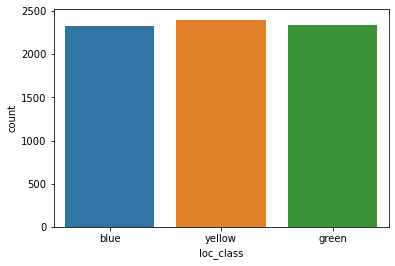

In [14]:
# check data distribution (ideally roughly same amount of data points for each class)

sns.countplot(x='loc_class',data=df_original)

In [15]:
df_original.corr()

,temp,humidity,baro_pressure,co_2,tvoc,uv_raw,amb_raw,uv_idx,lux,violet,indigo,blue,cyan,green,yellow,orange,red
temp,1.000000,-0.734280,0.113094,NaN,0.039319,-0.017834,-0.009580,-0.019173,-0.009644,-0.231265,-0.297060,-0.358803,-0.389672,-0.382005,-0.389147,-0.414223,-0.461486
humidity,-0.734280,1.000000,-0.037607,NaN,0.049758,0.092982,0.060355,0.093033,0.060363,0.155272,0.187309,0.217075,0.223219,0.212771,0.210898,0.218723,0.273325
baro_pressure,0.113094,-0.037607,1.000000,NaN,-0.031559,0.077383,0.051335,0.076954,0.051111,-0.000524,-0.045816,-0.097824,-0.122666,-0.122200,-0.121610,-0.140717,-0.153799
co_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tvoc,0.039319,0.049758,-0.031559,NaN,1.000000,0.081377,0.116430,0.081679,0.116731,0.039467,0.029342,0.024339,0.020832,0.019328,0.017254,0.014410,0.018961
uv_raw,-0.017834,0.092982,0.077383,NaN,0.081377,1.000000,0.945224,0.996612,0.945357,0.799095,0.739695,0.694081,0.667091,0.665679,0.658449,0.625658,0.613718
amb_raw,-0.009580,0.060355,0.051335,NaN,0.116430,0.945224,1.000000,0.947635,0.999795,0.837482,0.779895,0.734223,0.706970,0.704950,0.697618,0.664027,0.649510
uv_idx,-0.019173,0.093033,0.076954,NaN,0.081679,0.996612,0.947635,1.000000,0.947785,0.801681,0.742355,0.696694,0.669592,0.668165,0.660915,0.628094,0.616170
lux,-0.009644,0.060363,0.051111,NaN,0.116731,0.945357,0.999795,0.947785,1.000000,0.837640,0.779980,0.734314,0.707082,0.705092,0.697756,0.664140,0.649583
violet,-0.231265,0.155272,-0.000524,NaN,0.039467,0.799095,0.837482,0.801681,0.837640,1.000000,0.984229,0.953102,0.924908,0.924005,0.916044,0.879620,0.870897


<AxesSubplot:xlabel='temp', ylabel='humidity'>

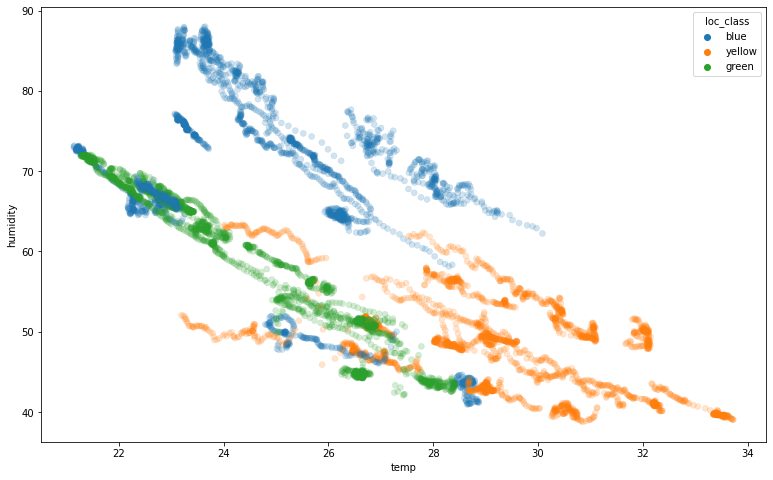

In [16]:
plt.figure(figsize=(13,8))
sns.scatterplot(x='temp', y='humidity', data=df_original,
                edgecolor=None, alpha=0.2,
                hue='loc_class')

<AxesSubplot:xlabel='uv_idx', ylabel='loc_class'>

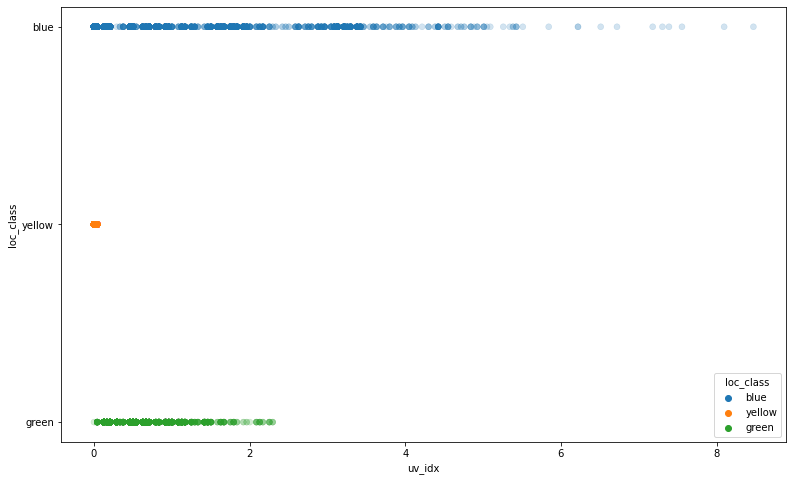

In [17]:
plt.figure(figsize=(13,8))
sns.scatterplot(x='uv_idx', y='loc_class', data=df_original,
                edgecolor=None, alpha=0.2,
                hue='loc_class')

In [18]:
df_original['tvoc'].value_counts()

0      6964
28        3
17        3
19        3
80        3
       ... 
94        1
98        1
138       1
150       1
161       1
Name: tvoc, Length: 84, dtype: int64

<AxesSubplot:xlabel='co_2', ylabel='tvoc'>

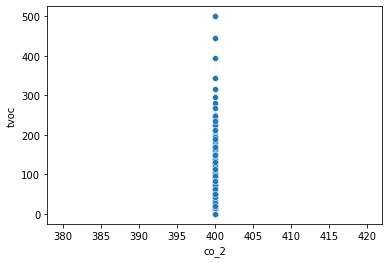

In [19]:
sns.scatterplot(x='co_2', y='tvoc', data=df_original)

In [20]:
df_original['co_2'].value_counts()

400    7063
Name: co_2, dtype: int64

In [21]:
df = df_original.drop(columns=['DTG', 'co_2', 'uv_raw', 'amb_raw'], axis=1)

In [22]:
df.head()

,temp,humidity,baro_pressure,tvoc,uv_idx,lux,violet,indigo,blue,cyan,green,yellow,orange,red,loc_class
0,28.568,42.925,1020.728,0,4.090,47338.4,65535,65535,65535,65535,65535,65535,65535,65535,blue
1,28.612,42.682,1020.742,0,4.132,47916.8,65535,65535,65535,65535,65535,65535,65535,65535,blue
2,28.619,42.151,1020.720,0,4.216,48069.6,65535,65535,65535,65535,65535,65535,65535,65535,blue
3,28.595,41.746,1020.713,0,4.090,46434.4,65535,65535,65535,65535,65535,65535,65535,65535,blue
4,28.629,41.451,1020.549,0,2.254,23488.8,56330,65535,65535,65535,65535,65535,65535,65535,blue


In [23]:
df.corr()

,temp,humidity,baro_pressure,tvoc,uv_idx,lux,violet,indigo,blue,cyan,green,yellow,orange,red
temp,1.000000,-0.734280,0.113094,0.039319,-0.019173,-0.009644,-0.231265,-0.297060,-0.358803,-0.389672,-0.382005,-0.389147,-0.414223,-0.461486
humidity,-0.734280,1.000000,-0.037607,0.049758,0.093033,0.060363,0.155272,0.187309,0.217075,0.223219,0.212771,0.210898,0.218723,0.273325
baro_pressure,0.113094,-0.037607,1.000000,-0.031559,0.076954,0.051111,-0.000524,-0.045816,-0.097824,-0.122666,-0.122200,-0.121610,-0.140717,-0.153799
tvoc,0.039319,0.049758,-0.031559,1.000000,0.081679,0.116731,0.039467,0.029342,0.024339,0.020832,0.019328,0.017254,0.014410,0.018961
uv_idx,-0.019173,0.093033,0.076954,0.081679,1.000000,0.947785,0.801681,0.742355,0.696694,0.669592,0.668165,0.660915,0.628094,0.616170
lux,-0.009644,0.060363,0.051111,0.116731,0.947785,1.000000,0.837640,0.779980,0.734314,0.707082,0.705092,0.697756,0.664140,0.649583
violet,-0.231265,0.155272,-0.000524,0.039467,0.801681,0.837640,1.000000,0.984229,0.953102,0.924908,0.924005,0.916044,0.879620,0.870897
indigo,-0.297060,0.187309,-0.045816,0.029342,0.742355,0.779980,0.984229,1.000000,0.987465,0.966719,0.964504,0.957921,0.928952,0.919291
blue,-0.358803,0.217075,-0.097824,0.024339,0.696694,0.734314,0.953102,0.987465,1.000000,0.991841,0.989816,0.985667,0.964518,0.958159
cyan,-0.389672,0.223219,-0.122666,0.020832,0.669592,0.707082,0.924908,0.966719,0.991841,1.000000,0.995582,0.995187,0.985098,0.974262


In [24]:
df.columns

Index(['temp', 'humidity', 'baro_pressure', 'tvoc', 'uv_idx', 'lux', 'violet',
       'indigo', 'blue', 'cyan', 'green', 'yellow', 'orange', 'red',
       'loc_class'],
      dtype='object')

In [25]:
df.head()

,temp,humidity,baro_pressure,tvoc,uv_idx,lux,violet,indigo,blue,cyan,green,yellow,orange,red,loc_class
0,28.568,42.925,1020.728,0,4.090,47338.4,65535,65535,65535,65535,65535,65535,65535,65535,blue
1,28.612,42.682,1020.742,0,4.132,47916.8,65535,65535,65535,65535,65535,65535,65535,65535,blue
2,28.619,42.151,1020.720,0,4.216,48069.6,65535,65535,65535,65535,65535,65535,65535,65535,blue
3,28.595,41.746,1020.713,0,4.090,46434.4,65535,65535,65535,65535,65535,65535,65535,65535,blue
4,28.629,41.451,1020.549,0,2.254,23488.8,56330,65535,65535,65535,65535,65535,65535,65535,blue
